In [1]:
# import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os, glob
from __future__ import unicode_literals
from IPython.core.display import display, HTML
import radical.pilot as rp
import radical.utils as ru
import radical.analytics as ra
from radical.entk import Profiler
import numpy as np
from math import sqrt
import pandas as pd

pd.set_option('expand_frame_repr', False)
pd.set_option('display.max_rows', 50)

%matplotlib inline

In [2]:
# Global configurations
# ---------------------

# Expand the notebook to the width of the browser
display(HTML("<style>.container { width:100% !important; }</style>"))

# Matplotlib style
plt.style.use('seaborn-colorblind')

# Use LaTeX and its body font for the diagrams' text.
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif']  = ['Nimbus Roman Becker No9L']

# Font sizes
SIZE = 24
FONTSIZE = SIZE
plt.rc('font', size=SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)  # fontsize of the x any y labels
plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE-2)  # legend fontsize
plt.rc('figure', titlesize=SIZE)  # # size of the figure title

# Use thinner lines for axes to avoid distractions.
mpl.rcParams['axes.linewidth']    = 1
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.minor.width'] = 1
mpl.rcParams['lines.linewidth'] = 2


# Do not use a box for the legend to avoid distractions.
mpl.rcParams['legend.frameon'] = False

# Restore part of matplotlib 1.5 behavior
mpl.rcParams['patch.force_edgecolor'] = True
mpl.rcParams['errorbar.capsize'] = 3

# Helpers
# -------

# Use coordinated colors. These are the "Tableau 20" colors as 
# RGB. Each pair is strong/light. For a theory of color    
tableau20 = [(31 , 119, 180), (174, 199, 232), # blue        [ 0,1 ]
             (255, 127, 14 ), (255, 187, 120), # orange      [ 2,3 ]
             (44 , 160, 44 ), (152, 223, 138), # green       [ 4,5 ]
             (214, 39 , 40 ), (255, 152, 150), # red         [ 6,7 ]
             (148, 103, 189), (197, 176, 213), # purple      [ 8,9 ]
             (140, 86 , 75 ), (196, 156, 148), # brown       [10,11]
             (227, 119, 194), (247, 182, 210), # pink        [12,13]
             (188, 189, 34 ), (219, 219, 141), # yellow      [14,15]
             (23 , 190, 207), (158, 218, 229), # cyan        [16,17]
             (65 , 68 , 81 ), (96 , 99 , 106), # gray        [18,19]
             (127, 127, 127), (143, 135, 130), # gray        [20,21] 
             (165, 172, 175), (199, 199, 199), # gray        [22,23]
             (207, 207, 207)]                   # gray        [24]
  
# Scale the RGB values to the [0, 1] range, which is the format 
# matplotlib accepts.    
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)    

# Return a single plot without right and top axes
def fig_setup(num_x, num_y, (size_x, size_y), (space_x, space_y)=(0.25,0.25)):
    fig, axes = plt.subplots(num_x, num_y, figsize=(size_x, size_y), gridspec_kw={'wspace':space_x, 'hspace':space_y}, sharex=False, sharey=False)
    if num_x == 1 and num_y == 1:
        axes = [[axes]]
#         for ax1 in axes:
#             for ax2 in ax1:
#                 ax2.get_xaxis().tick_bottom()  
#                 ax2.get_yaxis().tick_left()
    elif (num_x == 1 and num_y>1) or (num_x>1 and num_y == 1):
        axes = [axes]
#         for ax1 in axes:
#             for ax2 in ax1:
#                 ax2.get_xaxis().tick_bottom()  
#                 ax2.get_yaxis().tick_left()
    return fig, axes

In [3]:
def get_task_uids(path,s):
    
    f = open(path+'/radical.entk.wfprocessor.0000-proc.prof','r').readlines()
    task_uids = []
    for line in f:
        for word in line.split(','):
            if word.startswith('radical.entk.task.') and word not in task_uids:
                task_uids.append(word)   
    return task_uids

In [4]:
def get_adapt_time(path):
    f = f = open(path+'/radical.entk.wfprocessor.0000-obj.prof','r').readlines()
    t_start=0
    t_stop=0
    dur = 0.0
    for line in f:
        words = line.split(',')
        if words[1].startswith('executing post-exec'):
            t_start = float(words[0])
        if words[1].startswith('post-exec executed'):
            t_stop = float(words[0])
        if t_start > 0 and t_stop > 0:
            dur += t_stop - t_start
            t_start=0
            t_stop=0
    return dur

In [5]:
def get_data(df, df_err, loc):
    '''
    Columns on the dataframe
    'EnTK setup overhead','EnTK tear-down overhead', 'RTS tear-down overhead', 
    'EnTK management overhead', 'EnTK adaptivity overhead','RTS overhead', 
    'Execution time'
    '''
        
    trials=3
    stages = [16,32,64]

    for s in stages:
        
        entk_setup_ov_list = list()
        entk_teardown_ov_list = list()
        rp_teardown_ov_list = list()
        entk_mgmt_ov_list = list()
        entk_adap_ov_list = list()
        rp_ov_list = list()
        exec_list = list()
        
        for t in range(1,trials+1):
        
            path = '%s/trial_%s/adap-%s/rp.session.*.json'%(loc,t,s)
            json_files = glob.glob(path)        
            json_file = json_files[0]
            json      = ru.read_json(json_file)
            sid       = os.path.basename(json_file)[:-5]

            print sid, s, t
            session = ra.Session(sid=sid, stype='radical.pilot', src=os.path.dirname(path))
            units = session.filter(etype='unit', inplace=False)
            session = ra.Session(sid=sid, stype='radical.pilot', src=os.path.dirname(path))
            pilots = session.filter(etype='pilot', inplace=False)
            
#             for pilot in pilots.get():
#                 print pilot
                
            p = Profiler(src=os.path.dirname(path))        
            task_uids = get_task_uids(os.path.dirname(path),s)

            entk_dur = p.duration(task_uids, states=['SCHEDULING', 'DONE'])    
            # Time taken in appmanager to rreq function call
            entk_core_1 = p.duration('radical.entk.appmanager.0000', events=['create amgr obj', 'init rreq submission'])
            # Time taken to create resource manager obj
            entk_core_2 = p.duration('radical.entk.resource_manager.0000', events = ['create rmgr obj', 'rmgr obj created'])
            # Time taken to tear down appmanager
            entk_teardown_1 = p.duration('radical.entk.appmanager.0000', events=['start termination', 'termination done'])
            # Time taken to deallocate resource reservation
            entk_teardown_2 = p.duration('radical.entk.resource_manager.0000', events = ['canceling resource allocation', 'resource allocation cancelled'])
            # Time to adapt
            entk_adapt = get_adapt_time(os.path.dirname(path))
            
            
            rp_dur = units.duration([rp.NEW, rp.DONE])
            exec_dur = units.duration(event=[{ru.EVENT: 'exec_start'},
                                             {ru.EVENT: 'exec_stop'}])
#             print pilots.duration([rp.PMGR_ACTIVE, rp.FINAL])
    
#             session = ra.Session(sid=sid, stype='radical.pilot', src=os.path.dirname(path))
#             session.filter(etype=['unit'])
#             unit_uids = sorted(session.list('uid'))
#             e_dur_tot = 0.0
#             rp_tot = 0.0
#             ex_dur_tot = 0.0
#             for i in range(len(task_uids)/16):
#                 e_dur = p.duration(task_uids[i*16:(i+1)*16], states=['SCHEDULING','DONE']) 
#                 session = ra.Session(sid=sid, stype='radical.pilot', src=os.path.dirname(path))
#                 units = session.filter(uid=unit_uids[i*16:(i+1)*16], etype='unit', inplace=False)
#                 rp_d = units.duration([rp.NEW, rp.DONE])
#                 ex_dur = units.duration(event=[{ru.EVENT: 'exec_start'}, {ru.EVENT: 'exec_stop'}])
#                 e_dur_tot += e_dur - rp_d
#                 rp_tot += rp_d - ex_dur
#                 ex_dur_tot += ex_dur
                
#             print e_dur_tot, rp_tot, ex_dur_tot
    
            # 'EnTK setup overhead'
            entk_setup_ov = entk_core_1 + entk_core_2
            # EnTK teardown overhead'
            entk_teardown_ov = entk_teardown_1 - entk_teardown_2
            # RP cancelation overhead'
            entk_rp_cancel_ov = entk_teardown_2
            # 'EnTK task management overhead'
            entk_task_mgmt_ov = entk_dur - rp_dur
            # 'RP overhead'
            rp_ov = rp_dur - exec_dur

            entk_setup_ov_list.append(entk_setup_ov)
            entk_teardown_ov_list.append(entk_teardown_ov)
            rp_teardown_ov_list.append(entk_rp_cancel_ov)
            entk_mgmt_ov_list.append(entk_task_mgmt_ov)
            rp_ov_list.append(rp_ov)
            exec_list.append(exec_dur)
            entk_adap_ov_list.append(entk_adapt)
    
        df.loc[s] = [np.mean(entk_setup_ov_list), 
                           np.mean(entk_teardown_ov_list), 
                           np.mean(rp_teardown_ov_list), 
                           np.mean(entk_mgmt_ov_list), 
                           np.mean(entk_adap_ov_list),
                           np.mean(rp_ov_list),
                           np.mean(exec_list)]
    
        df_err.loc[s] = [np.std(entk_setup_ov_list)/sqrt(trials), 
                             np.std(entk_teardown_ov_list)/sqrt(trials), 
                             np.std(rp_teardown_ov_list)/sqrt(trials),
                             np.std(entk_mgmt_ov_list)/sqrt(trials), 
                             np.std(entk_adap_ov_list)/sqrt(trials),
                             np.std(rp_ov_list)/sqrt(trials),
                             np.std(exec_list)/sqrt(trials)]

In [6]:
df_tc = pd.DataFrame(columns=[ 'EnTK setup overhead','EnTK tear-down overhead', 'RTS tear-down overhead', 
                            'EnTK management overhead', 'EnTK adaptivity overhead','RTS overhead', 
                            'Execution time'])
df_tc_err = pd.DataFrame(columns=[ 'EnTK setup overhead','EnTK tear-down overhead', 'RTS tear-down overhead', 
                            'EnTK management overhead', 'EnTK adaptivity overhead','RTS overhead', 
                            'Execution time'])

df_to = pd.DataFrame(columns=[ 'EnTK setup overhead','EnTK tear-down overhead', 'RTS tear-down overhead', 
                            'EnTK management overhead', 'EnTK adaptivity overhead','RTS overhead', 
                            'Execution time'])
df_to_err = pd.DataFrame(columns=[ 'EnTK setup overhead','EnTK tear-down overhead', 'RTS tear-down overhead', 
                            'EnTK management overhead', 'EnTK adaptivity overhead','RTS overhead', 
                            'Execution time'])

df_ta = pd.DataFrame(columns=[ 'EnTK setup overhead','EnTK tear-down overhead', 'RTS tear-down overhead', 
                            'EnTK management overhead', 'EnTK adaptivity overhead','RTS overhead', 
                            'Execution time'])
df_ta_err = pd.DataFrame(columns=[ 'EnTK setup overhead','EnTK tear-down overhead', 'RTS tear-down overhead', 
                            'EnTK management overhead', 'EnTK adaptivity overhead','RTS overhead', 
                            'Execution time'])

get_data(df_tc, df_tc_err, './task-count-adap/raw_data')
get_data(df_to, df_to_err,'./task-order-adap/raw_data')
get_data(df_ta, df_ta_err,'./task-attribute-adap/raw_data')

print df_tc
print df_tc_err
print df_to
print df_to_err
print df_ta
print df_ta_err

rp.session.two.vivek.017611.3529 16 1
rp.session.two.vivek.017612.0045 16 2
rp.session.two.vivek.017612.32088 16 3
rp.session.two.vivek.017611.8524 32 1
rp.session.two.vivek.017612.3381 32 2
rp.session.two.vivek.017613.162388 32 3
rp.session.two.vivek.017611.27924 64 1
rp.session.two.vivek.017612.9853 64 2
rp.session.two.vivek.017613.169212 64 3
rp.session.two.vivek.017611.13231 16 1
rp.session.two.vivek.017612.31261 16 2
rp.session.two.vivek.017613.164783 16 3
rp.session.two.vivek.017611.22178 32 1
rp.session.two.vivek.017612.35238 32 2
rp.session.two.vivek.017613.176036 32 3
rp.session.two.vivek.017611.29291 64 1
rp.session.two.vivek.017612.52018 64 2
rp.session.two.vivek.017613.202205 64 3
rp.session.two.vivek.017611.29565 16 1
rp.session.two.vivek.017613.157937 16 2
rp.session.two.vivek.017613.162662 16 3
rp.session.two.vivek.017611.54181 32 1
rp.session.two.vivek.017612.31807 32 2
rp.session.two.vivek.017613.172624 32 3
rp.session.two.vivek.017611.63784 64 1
rp.session.two.vivek.0

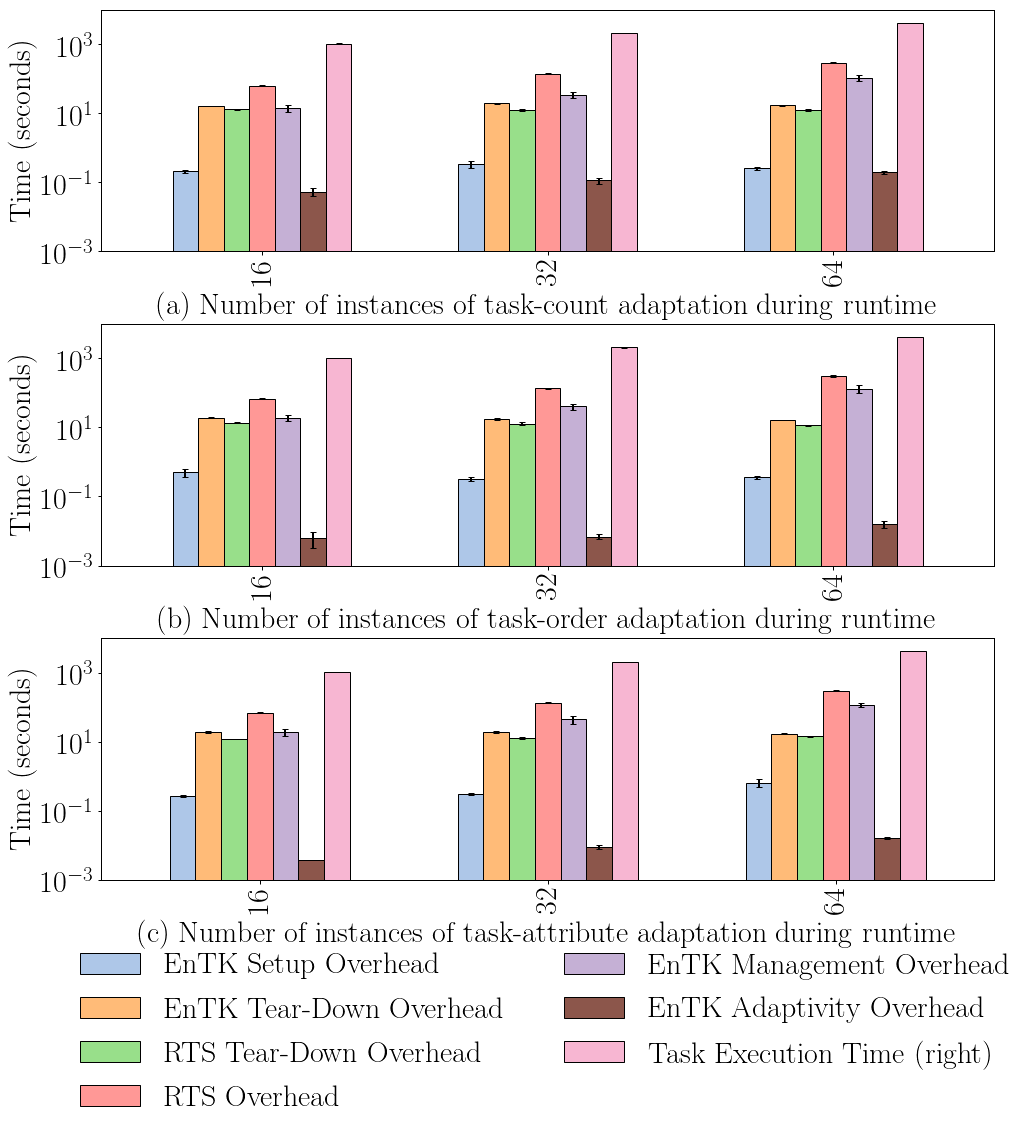

In [21]:
fig, ax = fig_setup(3,1,(16,16),(.3,.3))
FONTSIZE=30
width=0.125
ax1_tc = df_tc[[ 'EnTK setup overhead','EnTK tear-down overhead', 'RTS tear-down overhead', 
                 'RTS overhead', 'EnTK management overhead', 'EnTK adaptivity overhead',
                 'Execution time']].plot(
                     kind='bar', 
                     ax=ax[0][0],
                     yerr=df_tc_err,
                     fontsize=FONTSIZE,
                     width=5*width,
                     legend=False,
                     logy=True,
                     color = [tableau20[1],tableau20[3],tableau20[5],tableau20[7],
                             tableau20[9],tableau20[10],tableau20[13]],
                     ylim=(0.001,10000))

# ax2_tc = df_tc['Execution time'].plot(ax=ax[0][0], 
#                                         legend=False,
#                                         yerr = df_tc_err['Execution time'],
#                                         kind='bar', 
#                                         secondary_y=True,
#                                         width=width,
#                                         rot=0,
#                                         color=tableau20[10],
#                                         position=0)

ax1_tc.set_ylabel('Time (seconds)', fontsize=FONTSIZE)
tc_xlabel = ax1_tc.set_xlabel('(a) Number of instances of task-count adaptation during runtime', fontsize=FONTSIZE)
# ax1_tc.set_title(ax1_tc.get_title(), fontsize=FONTSIZE)
# ax2_tc.set_ylabel('Time (seconds)', fontsize=FONTSIZE)
# ax2_tc.set_ylim(0,6000)
plt.gca().set_xlim([-1.,2.5])


ax1_to = df_to[[ 'EnTK setup overhead','EnTK tear-down overhead', 'RTS tear-down overhead', 
                 'RTS overhead', 'EnTK management overhead', 'EnTK adaptivity overhead',
                 'Execution time']].plot(
                     kind='bar', 
                     ax=ax[0][1],
                     yerr=df_to_err,
                     fontsize=FONTSIZE,
                     width=5*width,
                     legend=False,
                     logy=True,
                     color = [tableau20[1],tableau20[3],tableau20[5],tableau20[7],
                             tableau20[9],tableau20[10],tableau20[13]],
                     ylim=(0.001,10000))

# ax2_to = df_to['Execution time'].plot(ax=ax[0][1], 
#                                         legend=False,
#                                         yerr = df_to_err['Execution time'],
#                                         kind='bar', 
#                                         secondary_y=True,
#                                         width=width,
#                                         rot=0,
#                                         color=tableau20[10],
#                                         position=0)


ax1_to.set_ylabel('Time (seconds)', fontsize=FONTSIZE)
to_xlabel = ax1_to.set_xlabel('(b) Number of instances of task-order adaptation during runtime', fontsize=FONTSIZE)
# ax1_to.set_title(ax1_to.get_title(), fontsize=FONTSIZE)
# ax2_to.set_ylabel('Time (seconds)', fontsize=FONTSIZE)
# ax2_to.set_ylim(0,6000)
plt.gca().set_xlim([-1.,2.5])


ax1_ta = df_ta[[ 'EnTK setup overhead','EnTK tear-down overhead', 'RTS tear-down overhead', 
                 'RTS overhead', 'EnTK management overhead', 'EnTK adaptivity overhead',
                 'Execution time']].plot(
                     kind='bar', 
                     ax=ax[0][2],
                     yerr=df_ta_err,
                     fontsize=FONTSIZE,
                     width=5*width,
                     legend=False,
                     logy=True,
                     color = [tableau20[1],tableau20[3],tableau20[5],tableau20[7],
                             tableau20[9],tableau20[10],tableau20[13]],
                     ylim=(0.001,10000))

# ax2_ta = df_ta['Execution time'].plot(ax=ax[0][2], 
#                                         legend=False,
#                                         yerr = df_ta_err['Execution time'],
#                                         kind='bar', 
#                                         secondary_y=True,
#                                         width=width,
#                                         rot=0,
#                                         color=tableau20[10],
#                                         position=0)


ax1_ta.set_xlabel('(c) Number of instances of task-attribute adaptation during runtime', fontsize=FONTSIZE)
ax1_ta.set_ylabel('Time (seconds)', fontsize=FONTSIZE)
# ax1_ta.set_title(ax1_ta.get_title(), fontsize=FONTSIZE)
# ax2_ta.set_ylabel('Time (seconds)', fontsize=FONTSIZE)
# ax2_ta.set_ylim(0,6000)
plt.gca().set_xlim([-0.55,2.55])





plt.setp([a.get_xticklabels() for a in ax[0]], visible=True)
plt.setp([tc_xlabel, to_xlabel], visible=True)

# plt.setp([a.get_yticklabels() for a in ax[:, 1]], visible=True)
# plt.setp([df1_xlabel, df2_xlabel], visible=True)



h1, l1 = ax1_tc.get_legend_handles_labels()
# h2, l2 = ax2_tc.get_legend_handles_labels()
labels = ['EnTK Setup Overhead', 
          'EnTK Tear-Down Overhead', 
          'RTS Tear-Down Overhead',
          'RTS Overhead',
          'EnTK Management Overhead',
          'EnTK Adaptivity Overhead',          
          'Task Execution Time (right)']
# handles = h1 + h2
handles = h1
plt.legend(handles, labels, loc = 'lower center', bbox_to_anchor = (0.01,-0.1,1,1), bbox_transform = plt.gcf().transFigure, ncol=2, fontsize=FONTSIZE )

fig.savefig('./entk_rp_adap_overheads_stress_supermic.pdf', dpi=100, bbox_inches='tight')
fig.savefig('./entk_rp_adap_overheads_stress_supermic.png', dpi=100, bbox_inches='tight')